In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from exp_analysis import *

In [35]:
case = 'light'

In [41]:
pars = {}
pars['heavy'] = {
    'm4' : [0.1, 0.2, 0.3, 0.4],
    'mz_prime': [1.25],
}
pars['light'] = {
    'm4' : [0.1, 0.2, 0.3, 0.4, 0.5], 
    'mz_prime': [0.03],
}

ctaus = [1, 5, 10, 20, 50, 100, 200]
!mkdir ../../fig/kde_test/
save_folder = "../../fig/kde_test/"
produce_samples = False

mkdir: ../../fig/kde_test/: File exists


In [42]:
#generation part
if produce_samples:
    for m4, mz_prime in itertools.product(pars[case]['m4'], pars[case]['mz_prime']):
        print(m4, mz_prime)
        if case == 'light':
            dark_gen_run = f'cd ..; ./dark_gen.py --M4 {m4} --mzprime {mz_prime} --UMU4 8e-9 --alpha_dark 0.25 --alpha_epsilon2 2e-10 --hierarchy light_mediator --neval 100000 --noplot'
        elif case == 'heavy':
            dark_gen_run = f'cd ..; ./dark_gen.py --M4 {m4} --mzprime {mz_prime} --UMU4 2.2e-7 --alpha_dark 0.4 --epsilon2 4.6e-4 --neval 100000 --noplot --hierarchy heavy_mediator'
        else:
            print('No good case selected')
        stream = os.popen(dark_gen_run)
        print(stream.read())

In [43]:
aux_gamma = []
aux_sigma = []
aux_n_evt = []
mz_prime = pars[case]['mz_prime'][0]
dfs = {}
for m4 in pars[case]['m4']:
    dfs[m4] = pd.read_pickle(f'../data/nd280_nu/3plus1/m4_{m4}_mzprime_{mz_prime}/MC_m4_{m4}_mzprime_{mz_prime}.pckl')
    initialise_df(dfs[m4], ctaus=[25])
    aux_gamma.append(dfs[m4]['weight_decay', ''][dfs[m4]['lead', '']].sum())
    aux_sigma.append(dfs[m4]['adjusted_weight', ''][dfs[m4]['lead', '']].sum())
    aux_n_evt.append(dfs[m4]['actual_weight', ''].sum())

aux_gamma = np.array(aux_gamma)
aux_sigma = np.array(aux_sigma)
aux_n_evt = np.array(aux_n_evt)

In [44]:
n_evt = 100000
df_base = pd.read_pickle(f'../data/nd280_nu/3plus1/scan/light_mediator/0.05_m4_0.5_0.0299_mzprime_0.0301_nevt_{n_evt}.pckl')
# df_base = pd.read_pickle('../data/nd280_nu/3plus1/scan/light_mediator/0.39_m4_0.41_0.0299_mzprime_0.0301_nevt_100000.pckl')
# df_base = pd.read_pickle('../data/nd280_nu/3plus1/scan/heavy_mediator/0.05_m4_0.5_1.24_mzprime_1.26_nevt_100000.pckl')
initialise_df(df_base, ctaus=[25], is_scan=True)

KeyError: ('total_decay_rate', '')

In [ ]:
# produce the gamma profile
m4_span = np.linspace(df_base['m4', ''].min(), df_base['m4', ''].max(), 20)
bins = 20
bin_range = [df_base['m4', ''].min(), df_base['m4', ''].max()]
bin_span = (bin_range[1] - bin_range[0])
bin_width = bin_span/bins

plt.plot(pars[case]['m4'], aux_gamma, 'o', label='true function')

mask = df_base['lead', '']
m4_values = df_base['m4', ''][mask].values
weight_decay_values = df_base['weight_decay', ''][mask].values

for sigma in [0.03]:
    f_est, var = kde_interpolation_m4(m4_span, 
                          m4_values, 
                          weight_decay_values, 
                          sigma,
                          kernel='gaus')
    plt.plot(m4_span, f_est, label=f'kde gaussian, $\sigma$={sigma:.2g}')
    plt.fill_between(m4_span, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)

for sigma in [0.03]:
    f_est, var = kde_interpolation_m4(m4_span, 
                          m4_values, 
                          weight_decay_values, 
                          sigma,
                          kernel='unif')
    plt.plot(m4_span, f_est, label=f'kde spherical, $\sigma$={sigma:.2g}')
    plt.fill_between(m4_span, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)
out = plt.hist(m4_values, bins=bins, range=bin_range,
               weights=weight_decay_values*bins,
               histtype='step', label='histogram')

plt.legend(frameon=False, loc='upper left')
plt.xlabel(r'$M_4$ [GeV]')
plt.ylabel('Decay rate')
# plt.yscale('log')
# plt.ylim(0, 1e-7)
plt.xlim(bin_range)
plt.title(f'Test with N random = {n_evt}\n{case} mediator, mzprime = 0.03 GeV, only lead')
plt.tight_layout()
# plt.savefig(save_folder+f'gamma_nevt_{n_evt}.png', dpi=250)

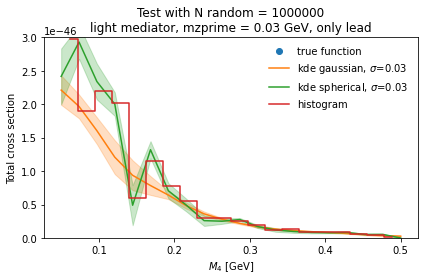

In [9]:
# produce the sigma profile with global interpolation of gamma (I believe it's wrong)
m4_span = np.linspace(df_base['m4', ''].min(), df_base['m4', ''].max(), 20)
bins = 20
bin_range = [df_base['m4', ''].min(), df_base['m4', ''].max()]
bin_span = (bin_range[1] - bin_range[0])
bin_width = bin_span/bins

plt.plot(pars[case]['m4'], aux_sigma/aux_gamma, 'o', label='true function')
mask = df_base['lead', '']
m4_values = df_base['m4', ''][mask].values
weight_values = df_base['weight', ''][mask].values
weight_decay_values = df_base['weight_decay', ''][mask].values

for sigma in [0.03]:  
    gamma_est, gamma_var = kde_interpolation_m4(m4_span, 
                          m4_values, 
                          weight_decay_values, 
                          sigma,
                          kernel='gaus')
    sigma_est, sigma_var = kde_interpolation_m4(m4_span, 
                          m4_values, 
                          weight_values, 
                          sigma,
                          kernel='gaus')
    final_sigma_est = sigma_est/gamma_est
    final_sigma_var = final_sigma_est * np.sqrt((gamma_var/gamma_est)**2 + (sigma_var/sigma_est)**2)
    plt.plot(m4_span, final_sigma_est, label=f'kde gaussian, $\sigma$={sigma:.2g}')
    plt.fill_between(m4_span, final_sigma_est-final_sigma_var, final_sigma_est+final_sigma_var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)

for sigma in [0.03]:  
    gamma_est, gamma_var = kde_interpolation_m4(m4_span, 
                          m4_values, 
                          weight_decay_values, 
                          sigma,
                          kernel='unif')
    sigma_est, sigma_var = kde_interpolation_m4(m4_span, 
                          m4_values, 
                          weight_values, 
                          sigma,
                          kernel='unif')
    final_sigma_est = sigma_est/gamma_est
    final_sigma_est = np.nan_to_num(final_sigma_est)
    final_sigma_var = final_sigma_est * np.sqrt((gamma_var/gamma_est)**2 + (sigma_var/sigma_est)**2)
    final_sigma_var = np.nan_to_num(final_sigma_var)
    plt.plot(m4_span, final_sigma_est, label=f'kde spherical, $\sigma$={sigma:.2g}')
    plt.fill_between(m4_span, final_sigma_est-final_sigma_var, final_sigma_est+final_sigma_var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)


hist_gamma, edges = np.histogram(m4_values, bins=bins, range=bin_range,
               weights=weight_decay_values*bins)
hist_sigma, edges = np.histogram(m4_values, bins=bins, range=bin_range,
               weights=weight_values*bins)
plt.step((edges[:-1]+edges[1:])/2, hist_sigma/hist_gamma, where='mid', label='histogram')


plt.legend(frameon=False, loc='best')
plt.xlabel(r'$M_4$ [GeV]')
plt.ylabel('Total cross section')
# plt.xlim(bin_range)
plt.ylim(0, 3e-46)
plt.title(f'Test with N random = {n_evt}\n{case} mediator, mzprime = 0.03 GeV, only lead')
plt.tight_layout()
# plt.savefig(save_folder+f'sigma_nevt_{n_evt}.png', dpi=250)

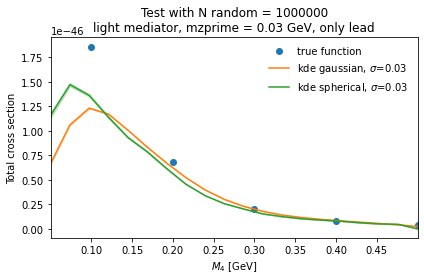

In [10]:
# produce the sigma profile with interpolation of gamma point by point 
m4_span = np.linspace(df_base['m4', ''].min(), df_base['m4', ''].max(), 20)
bins = 20
bin_range = [df_base['m4', ''].min(), df_base['m4', ''].max()]
bin_span = (bin_range[1] - bin_range[0])
bin_width = bin_span/bins

plt.plot(pars[case]['m4'], aux_sigma, 'o', label='true function')

mask = df_base['lead', '']
m4_values = df_base['m4', ''][mask].values
adjusted_weight_values = df_base['adjusted_weight', ''][mask].values

for sigma in [0.03]:
    f_est, var = kde_interpolation_m4(m4_span, 
                          m4_values, 
                          adjusted_weight_values, 
                          sigma,
                          kernel='gaus')
    plt.plot(m4_span, f_est, label=f'kde gaussian, $\sigma$={sigma:.2g}')
    plt.fill_between(m4_span, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)

for sigma in [0.03]:
    f_est, var = kde_interpolation_m4(m4_span, 
                          m4_values, 
                          adjusted_weight_values, 
                          sigma,
                          kernel='unif')
    plt.plot(m4_span, f_est, label=f'kde spherical, $\sigma$={sigma:.2g}')
    plt.fill_between(m4_span, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)
# out = plt.hist(m4_values, bins=bins, range=bin_range,
#                weights=adjusted_weight_values*bins,
#                histtype='step', label='histogram')

plt.legend(frameon=False, loc='best')
plt.xlabel(r'$M_4$ [GeV]')
plt.ylabel('Total cross section')
# plt.yscale('log')
# plt.ylim(0, 1e-7)
plt.xlim(bin_range)
plt.title(f'Test with N random = {n_evt}\n{case} mediator, mzprime = 0.03 GeV, only lead')
plt.tight_layout()
# plt.savefig(save_folder+f'sigma_correct_{n_evt}.png', dpi=250)

In [15]:
# produce the sigma profile with interpolation of gamma point by point 
m4_span = np.linspace(df_base['m4', ''].min(), df_base['m4', ''].max(), 20)
bins = 20
bin_range = [df_base['m4', ''].min(), df_base['m4', ''].max()]
bin_span = (bin_range[1] - bin_range[0])
bin_width = bin_span/bins

for material, mass in mass_material.items():
    aux_sigma = []
    for m4 in pars[case]['m4']:
        aux_sigma.append(dfs[m4]['adjusted_weight', ''][dfs[m4][material, '']].sum())
    aux_sigma = np.array(aux_sigma)

    plt.plot(pars[case]['m4'], aux_sigma, 'o', label='correct cross section')

    mask = df_base[material, '']
    m4_values = df_base['m4', ''][mask].values
    adjusted_weight_values = df_base['adjusted_weight', ''][mask].values

    for sigma in [0.03]:
        f_est, var = kde_interpolation_m4(m4_span, 
                            m4_values, 
                            adjusted_weight_values, 
                            sigma,
                            kernel='gaus')
        plt.plot(m4_span, f_est, label=f'kde gaussian, $\sigma$={sigma:.2g}')
        plt.fill_between(m4_span, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)

    for sigma in [0.03]:
        f_est, var = kde_interpolation_m4(m4_span, 
                            m4_values, 
                            adjusted_weight_values, 
                            sigma,
                            kernel='unif')
        plt.plot(m4_span, f_est, label=f'kde spherical, $\sigma$={sigma:.2g}')
        plt.fill_between(m4_span, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)

    plt.legend(frameon=False, loc='best')
    plt.xlabel(r'$M_4$ [GeV]')
    plt.ylabel('Total cross section')
    # plt.yscale('log')
    # plt.ylim(0, 1e-7)
    plt.xlim(bin_range)
    plt.title(f'Test with N random = {n_evt}\n{case} mediator, mzprime = 0.03 GeV, only {material}')
    plt.tight_layout()
    plt.savefig(save_folder+f'sigma_{material}_{n_evt}.png', dpi=250)
    plt.close()

In [9]:
# produce the n_evt profile at different stages in the selection
m4_span = np.linspace(df_base['m4', ''].min(), df_base['m4', ''].max(), 20)
bins = 20
bin_range = [df_base['m4', ''].min(), df_base['m4', ''].max()]
bin_span = (bin_range[1] - bin_range[0])
bin_width = bin_span/bins

ctau = 25
for mask in ['trivial', 'selected', f'decay_in_tpc_{ctau}', f'total_selected_{ctau}']:
    aux_n_evt = []
    for m4 in pars[case]['m4']:
        aux_mask = dfs[m4][mask, '']
        aux_n_evt.append(dfs[m4]['actual_weight', ''][aux_mask].sum())
    plt.plot(pars[case]['m4'], aux_n_evt, 'o', label='true function')

    aux_mask = df_base[mask, '']
    m4_values = df_base['m4', ''][aux_mask].values
    actual_weight_values = df_base['actual_weight', ''][aux_mask].values

    for sigma in [0.03]:
        f_est, var = kde_interpolation_m4(m4_span, 
                            m4_values, 
                            actual_weight_values, 
                            sigma,
                            kernel='gaus')
        plt.plot(m4_span, f_est, label=f'kde gaussian, $\sigma$={sigma:.2g}')
        plt.fill_between(m4_span, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)

    for sigma in [0.03]:
        f_est, var = kde_interpolation_m4(m4_span, 
                            m4_values, 
                            actual_weight_values, 
                            sigma,
                            kernel='unif')
        plt.plot(m4_span, f_est, label=f'kde spherical, $\sigma$={sigma:.2g}')
        plt.fill_between(m4_span, f_est-var, f_est+var, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)

    plt.legend(frameon=False, loc='best')
    plt.xlabel(r'$M_4$ [GeV]')
    plt.ylabel('Expected number of events')
    # plt.yscale('log')
    plt.ylim(bottom=0)
    plt.xlim(bin_range)
    plt.title(f'Test with N random = {n_evt}\n{case} mediator, mzprime = 0.03 GeV\n{mask}')
    plt.tight_layout()
    plt.savefig(save_folder+f'n_evt_{n_evt}_mask_{mask}.png', dpi=250)
    plt.close()